# Intelligent Systems

## Academic year 2024-2025

### Lab 2: Metaheuristic Seaarch
Carmen María Noblejas Carreto


Lucian Andrei Negoita

## Power and Service Stations: Finding the Optimal Configuration

## 1. Introduction

We were asked by **Ministry of Transport and Sustainable Mobility** to implement the algorithms developed during Lab1 in authonomous vehicle route planning with A* as it is the most effective for finding optimal path efficiently. The Ministry asked us to provide another algorithm using the work done that helps us to strategically establish service stations across urban areas to suppert the autonomous vehicle fleet. This stations will act as fleet hubs and provide essential vehicle services.

To achieve this, we are requested **to determine the optimal distribution of these stations** across the city maps. Taking into account that not every intersection is eligible as a station location and the preselection of candidates that the Ministry has done based on specific criteria. 

The primary focus is on sustainability and equitable access, aiming to ensure that all citizens are reasonably close to a service station. Only a specific number of candidates will be chosen. For helping us they have provided data on the population coverage for each candidate intersection, allowing us to consider both accessibility and coverage in our distribution strategy.

Our primary objective is to ensure efficient access for the maximum possible population coverage while maintaining an even distribution across the city. 

## 2. Problem Description

### 2.1 Input Problems

Each scenario will be provided in a `json` format file containing the following information, formatted as a dictionary with these keys:

* `address`: The address used.
* `distance`: Maximum radius used to define intersections and segments around the address.
* `intersections`: A list of dictionaries with information on intersections.
* `segments`: A list of dictionaries with information on segments, which represent streets between two intersections.
* `candidates`: A list of pairs (identifier, population), which contains the candidate intersections. Note that the identifiers in this list must be included in the list of intersections.
* `number_stations`: The number of vehicle stations to locate, which must not exceed the number of candidates.

Each dictionary in `intersections` includes three keys:

* `identifier`: Intersection identifier
* `longitude`: Longitude of the intersection
* `latitude`: Latitude of the intersection

Each dictionary in `segments` includes four keys:

* `origin`: Origin intersection
* `destination`: Destination intersection
* `distance`: Distance between the two intersections
* `speed`: Maximum speed allowed between the two intersections


### 2.2 Formal problem definition
We need to choose $s$ stations from a number of $c$ candidate or eligible intersections, with $s<=c$. Therefore, our **objective** is to decide at which of these $c$ candidate intersections we should locate the $s$ vehicle stations, so as to minimize the average travel time that each inhabitant takes from his home to the nearest station. If we denote by $S$ the vector of size $s$ containing the intersections in which the vehicle stations are located and by $C$ the vector of candidate intersections containing the pair (id, pop) for each candidate intersections, then formally, we want to solve the following optimization problem:

$$
S^* = \arg\min_{S} \frac{1}{\sum_{i=0}^{c-1} C[i].pop} \cdot \left\{\sum_{i=0}^{c-1} \; C[i].pop \cdot \min_{j=0,\dots,s-1} time(C[i].id,S[j])\right\}
$$

where:
- $C[i].pop$ accounts for the population (number of inhabitants) covered by the candidate intersection $i$.
- $C[i].int$ is the identifier of candidate intersection $i$.
- $time(A,B)$ accounts for the lowest real time to travel from intersection $A$ to intersection $B$. 
- $S$ contains exactly $s$ distinct intersections, which must all belong to the set of candidates solutions, and being $s<=c$

The following considerations must be done regarding the previous expression:
- We are dealing with a **minimization problem**
- The cardinality of the search space is:
$$
\binom{c}{s} = \frac{c!}{(c-s)!s!}
$$
for example if we have 20 eligible intersections and 4 vehicle stations the number of possible solutions is 210, not so many; but if we have 100 candidates and 10 sations, then the number of possible solutions is $1.7\times10^{13}$ ($5.3\times 10^{20}$ with 20 stations). 




## 3. Development of the lab assignment

Before implementing the algorithms, we have considered how to define the basic elements for this type of problems: 

- We have described a convenient representation for the solutions (configurations, chromosomes, individuals...) of the problem to be used in the combinatorial optimization algorithms.

- We have implemented an evaluation mechanism in order to manage the evaluations carried out by the combinatorial optimization algorithms taking into account that:

    - In the case A* returns no solution (cost = inf) replace this value by a very high number in comparison with the maximum time in our problem.
    - We are going to collect statistics and printout the results.
    - Re-use the code that we have from Lab1.

The problems now incorporate new information, which is the list of candidate intersection, and per every of them, the population that is covered. The number of stations to be located is also indicated in the problem as `number_stations`. 



### 3.1 Evaluation of a single solution

Given a specific instance of the problem to solve, and assuming that $C$ denotes its list of candidate intersections, the value of every possible solution $S$ should be computed as:

$$value(S) = \frac{1}{\sum_{i=0}^{c-1} C[i].pop} \cdot  \left\{\sum_{i=0}^{c-1} \; C[i].pop \cdot \min_{j=0,\dots,s-1} time(C[i].id,S[j])\right\}$$

according to the formula presented in section 2.2. 

##  IMPORTS NEEDED FOR THE DEVELOPMENT OF THE LAB2

In [62]:
import random
import heapq
import json
import time
import math
from datetime import timedelta
from abc import ABC, abstractmethod

## DEFINITION OF CONSTANTS AND VARIABLES FOR STORING STATISTICS

Here we have the different variables used for the recopilation of statistics and constants for penalization in A*.

In [63]:
# Define constants
PENALTY_UNREACHABLE = 18000  # 5 hours in seconds
EARTH_RADIUS = 6371000  # Earth radius in meters

# Global counters for debug
evaluate_solution_count = 0
unique_solutions_evaluated = set()
compute_travel_times_count = 0
unique_station_sets = set()

# Potential placeholders for real/unique counters
real_compute_travel_times_count = 0
real_evaluate_solution_count = 0

# Caches (the precompute is lower)
fitness_cache = {}


def haversine_distance(lat1, lon1, lat2, lon2):
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = (
        math.sin(dphi / 2.0) ** 2
        + math.cos(phi1) * math.cos(phi2) * math.sin(dlambda / 2.0) ** 2
    )
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return EARTH_RADIUS * c

We have also included the function haversine_distance() in which allows us to compute distances as geopy would do, but in an optimiced and more efficient way. In this way we reduce the execution time and cost

## REPRESENTATION OF STATES, ACTION, PROBLEMS... DEFINED IN LAB 1

### CLASS STATE

In [64]:
class State:
    def __init__(self, identifier, latitude, longitude):
        self.identifier = identifier
        self.latitude = latitude
        self.longitude = longitude
        self.neighbors = {}

    def __eq__(self, other):
        return isinstance(other, State) and self.identifier == other.identifier

    def __hash__(self):
        return hash(self.identifier)

    def __repr__(self):
        return f"State({self.identifier}, {self.latitude}, {self.longitude})"


##### Purpose:
* This class represents an intersection (state) in the city graph, it stores its unique identifier, geographical coordinates, and connected neighbors

##### Attributes:
* `Identifier`
* `Latitude, longitude`: Geographical coordinates of the intersection
* `Neighbours`: List of tuples with "neighboring" `States` objects and the `Actions` ofjects (road segments)

##### Methods:
* `__eq__(self, other)`: Determines the equality based on the state's identifier.
* `__hash__(self)` : Emables `State`objects to be used in sets and as dictionary keys. Returns a hash of the identifier.
* `__repr__(self)` : Returns a string representation of the `State` object (debugging purpose)

It is important to take into account that we have pre-sorted the Neighbors during initialization in the class `ImportJSON.py` for consistent traversal during searches. (We will see this class later on the notebook).

### CLASS ACTION

In [65]:
class Action:
    def __init__(self, origin, destination, speed):
        self.origin = origin
        self.destination = destination
        self.distance = haversine_distance(
            origin.latitude,
            origin.longitude,
            destination.latitude,
            destination.longitude,
        )
        self.speed = speed / 3.6  # Convert speed from km/h to m/s

    def cost(self):
        return self.distance / self.speed

    def __repr__(self):
        return f"Action({self.origin.identifier} -> {self.destination.identifier}, distance={self.distance:.2f}, speed={self.speed:.2f})"


##### Purpose:
* This class represents a road segment that connects two intersections (`States`) in the city. It includes information about the distance and speed limit.

##### Attributes:
* `Origin`: Starting state
* `Destination`: End state of the action 
* `Distance`: Between `origin` and `destination` (meters)
* `Speed`: Speed limit of the segment (converted to meters per second)

##### Methods:
* `cost(self)`: Returns the travel time and the calculated cost by dividing `distance` by the `speed` (seconds).
* `__repr__(self)`: Provides a string representation of the `Action` object for easy debugging and logging.

##### IMPORTANT THINGS TO TAKE INTO ACCOUNT:
* Speed is converted from kilometers per hour (km/h) to meters per second (m/s) by dividing by `3.6`. Ensuring consistent units when calculating the cost.
* The cost is calculated in seconds, reflecting the travel time for the segment.
* As a different with Lab1, here we are directly calculating the distance calling the haversine_distance() function.

#### TIME-HEURISTIC FUNCTION

In [66]:
def time_heuristic(current_state, goal_state):
    distance = haversine_distance(
        current_state.latitude,
        current_state.longitude,
        goal_state.latitude,
        goal_state.longitude,
    )
    # Assume a max speed (km/h)
    max_speed_kmh = 120.0
    max_speed_ms = max_speed_kmh / 3.6  # convert to m/s
    # Return the time (distance / speed) in seconds
    heuristic_time = distance / max_speed_ms
    return heuristic_time

### CLASS NODE

In [67]:
class Node:
    node_counter = 0

    def __init__(self, state, parent=None, action=None, path_cost=0, heuristic_cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.heuristic_cost = heuristic_cost
        self.f_cost = self.path_cost + self.heuristic_cost
        self.depth = 0 if parent is None else parent.depth + 1
        self.order = Node.node_counter
        Node.node_counter += 1

    def __lt__(self, other):
        return (self.f_cost, self.state.identifier) < (
            other.f_cost,
            other.state.identifier,
        )

##### Purpose:
* Represents a node in the search tree. It contains information about the current state, the action taken to reach it, and the cumulative cost and depth of the node.

##### Attributes:
* `State`: Current state (intersection)
* `Parent`: Parent node leadeing to the current one
* `Action`: Action taken to reach this node from the parent one
* `Path_cost`: Cummulative cost from the root to this node (seconds)
* `Heuristic_cost`: Heuristic estimated to the goal
* `F_cost`: Total cost for A*: (f = g + h)
* `Depth`: Depth of the node in the search tree
* `Order`: We store the iteration in which the node is created to sort it. We asign to it the counter.
* `Counter`: Counter to know the iteration in which the node is created.

##### Methods:
* `__repr__(self)`: Provides a string representation of the `Node`object, displaying the satate identifier, path cost, and depth for debugging 
* `__lt__(self, other)`: Comparison based on `f_cost` and then `id` for tie-breaking

##### NOTE:
* The `path_cost` represents the total travel time in seconds, accumulating the costs from the `Action` objects.

## FUNCTIONS FOR SOLVING THE PROBLEM

This function calculates the Euclidean distance between the current state and the goal state as the heuristic. Instead of using the geopy library as we did in lab one, now we are using the function defined above in order to make our code faster and more efficient.

#### ABSTRACTS CLASS OF THE SEARCH ALGORITHMS CALLING THE METHODS

In [68]:

# Abstract Base Class for Search Algorithms
class SearchAlgorithm(ABC):
    
    def search(self):
        global real_compute_travel_times_count
        start_state = self.problem.intersections[self.start_id]
        goal_state = self.problem.intersections[self.goal_id]
        start_heuristic = self.heuristic_func(start_state, goal_state)

        start_node = Node(start_state, None, None, 0, start_heuristic)
        self.add(start_node)
        self.frontier_state_costs[start_node.state] = 0

        while self.frontier:
            _, _, current_node = self.remove()
            if current_node.state.identifier == self.goal_id:
                real_compute_travel_times_count += 1
                return current_node.path_cost
            self.explore(current_node)
           
            # Pass `goal` to `expand`
            for child in self.expand(current_node, goal_state):
                if self.should_add_to_frontier(child):
                    self.add(child)
   

        return PENALTY_UNREACHABLE

    @abstractmethod
    def expand(self, node):
        pass

    @abstractmethod
    def explore(self, node):
        pass

    @abstractmethod
    def add(self, node):
        pass

    @abstractmethod
    def remove(self):
        pass


#### A* FUNCTION

In [69]:
import heapq

class AStarSearch(SearchAlgorithm):
    def __init__(self, problem, start_id, goal_id, heuristic_func):
        """
        problem: The problem instance
        start_id: intersection ID of the candidate
        goal_id: intersection goal.
        heuristic_func:
        """
        self.problem = problem
        self.start_id = start_id
        self.goal_id = goal_id
        self.heuristic_func = heuristic_func
        self.frontier = []
        self.explored = set()
        self.frontier_state_costs = {}


    def expand(self, node, goal_state):
        """Generate child nodes with heuristic costs."""
        children = []
        for next_state, action in node.state.neighbors.items():
            next_state = self.problem.intersections[next_state]
            new_cost = node.path_cost + action.cost()
            heuristic_cost = self.heuristic_func(next_state, goal_state)
            child = Node(
                next_state,
                parent=node,
                action=action,
                path_cost=new_cost,
                heuristic_cost=heuristic_cost,
            )
            child.f_cost = child.path_cost + child.heuristic_cost
            children.append(child)
        return children

    def explore(self, node):
        """Mark the node as explored."""
        self.explored.add(node.state)

    def add(self, node):
        """Add the node to the frontier."""
        heapq.heappush(self.frontier, (node.f_cost, node.order, node))
        self.frontier_state_costs[node.state] = node.path_cost

    def remove(self):
        """Remove and return the node with the lowest f_cost."""
        return heapq.heappop(self.frontier)

    def should_add_to_frontier(self, child):
        child_state = child.state
        child_cost = child.path_cost
        return child_state not in self.explored and (
            child_state not in self.frontier_state_costs
            or child_cost < self.frontier_state_costs[child_state]
        )


### CLASS PROBLEM


In [70]:
class Problem:
    def __init__(self, intersections, segments, candidates, number_stations):
        self.intersections = intersections
        self.segments = segments
        self.candidates = candidates
        self.number_stations = number_stations
        self.candidate_to_index = {
            cid: idx for idx, (cid, _) in enumerate(self.candidates)
        }
        self.index_to_candidate = {
            idx: cid for idx, (cid, _) in enumerate(self.candidates)
        }

    def get_neighbors(self, intersection_id):
        state = self.intersections[intersection_id]
        return [
            (neighbor_id, action.cost())
            for neighbor_id, action in state.neighbors.items()
        ]

##### Purpose:
* Represents the problem of navigating the city by defining the intersections, segments, candidates and number of stations allowed as well as the methods to interact with states and actions.

##### Attributes:
* `Intersections`: Dictionary of all `Action` objects.
* `Segments`: List of all `Action` objects, keyed by their identifiers.
* `Candidates`: List of tuples (identifier, population) containing the candidates intersections.
* `Number_stations`: The number of vehicle stations to locate, which must not exceed the number of candidates.
* `candidate_to_index`: 
* `index_to_candidate`: 

##### Methods:
Now we only have one method:
* `get_neighbours(self, intersections_id)`: Returns the list neighbors containing the neighbors of a state that it creates from the intersection_id provided.

#### FUNCTION COMPUTE TRAVEL TIMES A*

In [71]:
def compute_travel_times_astar(problem, stations, debug=False):
    """
    For each candidate intersection lookup from the precomputed table,
    picking the minimal cost among the chosen stations.
    """
    global compute_travel_times_count
    global precomputed_astar_table

    if debug:
        print("Computing travel times via precomputed A* table lookups...")

    # For each candidate -> minimal cost among stations
    minimal_travel_times = {}
    for candidate_id, _ in problem.candidates:
        best_cost = PENALTY_UNREACHABLE
        for station_id in stations:
            # Just a dictionary lookup
            cost = precomputed_astar_table.get(
                (candidate_id, station_id), PENALTY_UNREACHABLE
            )
            compute_travel_times_count += (
                1  
            )
            if cost < best_cost:
                best_cost = cost
        minimal_travel_times[candidate_id] = best_cost

    if debug:
        print("Lookup-based travel times computed.")
    return minimal_travel_times


## REPRESENTATION AND EVALUATING SOLUTIONS AND CONFIGURATIONS

### Representation of Solutions

Solution is a set of intersections (stations) and paths connecting them. This could be represented as:
* Selected Stations: A list of intersection identifiers that represent stations.
* Connections: Paths between consecutive stations


#### CLASS SOLUTION



In [72]:
class Solution:
    def __init__(
        self,
        problem,
        chromosome,
        penalty_unreachable,
        fitness_cache,
        astar_cache,
        compute_travel_func,
    ):
        """
        CONFIGURATION OF STATIONS
        given by the represetation of the binary chromosome.

        Parameters:
        - problem: instance of the problem.
        - chromosome: 0s and 1s list representing candidates stations.
        - penalty_unreachable: penalty for unreachable candidates.
        - fitness_cache: dictionary to cache fitness results.
        - astar_cache: dictionary to cache A* results.
        - compute_travel_func: function to compute travel times.
        """
        self.problem = problem
        self.chromosome = chromosome
        self.penalty_unreachable = penalty_unreachable
        self.fitness_cache = fitness_cache
        self.astar_cache = astar_cache
        self.compute_travel_times_astar = compute_travel_func

    def decode_chromosome(self):
        """
        Returns stations id (IDs intersections) choosen by the chrom.
        """
        return [
            self.problem.candidates[i][0]
            for i, bit in enumerate(self.chromosome)
            if bit == 1
        ]

    def evaluate(self):
        """
        Evauate solution, returns fitness.
        Uses cache if available.
        """
        chrom_tuple = tuple(self.chromosome)
        if chrom_tuple in self.fitness_cache:
            return self.fitness_cache[chrom_tuple]

        stations = self.decode_chromosome()
        total_population = sum(pop for _, pop in self.problem.candidates)

        travel_times = self.compute_travel_times_astar(self.problem, stations)

        total_weighted_time = 0
        for candidate_id, population in self.problem.candidates:
            travel_time = travel_times.get(candidate_id, PENALTY_UNREACHABLE)
            if travel_time == PENALTY_UNREACHABLE:
                travel_time = self.penalty_unreachable
            total_weighted_time += population * travel_time

        fitness = total_weighted_time / total_population
        self.fitness_cache[chrom_tuple] = fitness
        return fitness

This class represents a particular solution (a configuration of stations), given by a binary chromosome.

Parameters:
- problem: instance of the problem with intersections, candidates, etc.
- chromosome: list of 0s and 1s that represents which candidates are stations.
- penalty_unreachable: penalty for unreachable candidates.
- fitness_cache: dict to cache fitness results.
- astar_cache: dict to cache A* results.
- compute_travel_func: function to compute travel times.

Then we have the function `decode_chromosome` which returns a list of stations (identifier and intersections) chosen by the chromosome.

Finally we have the `evaluate` function which evaluates the solution, returning the fitness value using the cache if it is available

### EVALUATION FUNCTION

In [73]:
def evaluate_solution(problem, chromosome, debug=False):
    global evaluate_solution_count, real_evaluate_solution_count, unique_solutions_evaluated, fitness_cache
    global precomputed_astar_table
    evaluate_solution_count += 1

    chrom_tuple = tuple(chromosome)
    if chrom_tuple not in unique_solutions_evaluated:
        unique_solutions_evaluated.add(chrom_tuple)
        real_evaluate_solution_count += 1

    if debug:
        print("Evaluating solution...")

    # Instanciar la solución y evaluarla
    sol = Solution(
        problem,
        chromosome,
        PENALTY_UNREACHABLE,
        fitness_cache,
        precomputed_astar_table,
        compute_travel_times_astar,
    )
    fitness = sol.evaluate()

    if debug:
        print(f"Solution evaluation completed. Fitness: {fitness}")
    return fitness

## FUNCTIONS NEEDED FOR THE GENETIC ALGORITHM

#### Generate random chromosome

In [74]:
def generate_random_chromosome(problem):
    size = len(problem.candidates)
    chromosome = [0] * size
    ones_positions = random.sample(range(size), problem.number_stations)
    for pos in ones_positions:
        chromosome[pos] = 1
    return chromosome

#### One point crossover

In [75]:
def one_point_crossover(p1, p2):
    size = len(p1)
    point = random.randint(1, size - 1)
    o1 = p1[:point] + p2[point:]
    o2 = p2[:point] + p1[point:]
    return o1, o2

#### Repair chromosome

In [76]:
def repair_chromosome(chromosome, number_stations):
    current_ones = sum(chromosome)
    if current_ones == number_stations:
        return chromosome
    if current_ones > number_stations:
        ones_positions = [i for i, bit in enumerate(chromosome) if bit == 1]
        diff = current_ones - number_stations
        to_flip = random.sample(ones_positions, diff)
        for pos in to_flip:
            chromosome[pos] = 0
    else:
        zeros_positions = [i for i, bit in enumerate(chromosome) if bit == 0]
        diff = number_stations - current_ones
        to_flip = random.sample(zeros_positions, diff)
        for pos in to_flip:
            chromosome[pos] = 1
    return chromosome

#### Mutate

In [77]:
def mutate(chromosome, mutation_prob=0.2):
    if random.random() < mutation_prob:
        ones_positions = [i for i, bit in enumerate(chromosome) if bit == 1]
        zeros_positions = [i for i, bit in enumerate(chromosome) if bit == 0]
        if ones_positions and zeros_positions:
            pos1 = random.choice(ones_positions)
            pos2 = random.choice(zeros_positions)
            chromosome[pos1], chromosome[pos2] = chromosome[pos2], chromosome[pos1]
    return chromosome

#### Tournament selection

In [78]:
def tournament_selection(population, fitness, k=3):
    selected = random.sample(list(zip(population, fitness)), k)
    return min(selected, key=lambda x: x[1])[0]

## Strategies

### GENETIC ALGORITHM

In [79]:
import matplotlib.pyplot as plt

def genetic_algorithm(
    problem,
    generations=50,
    population_size=200,
    mutation_prob=0.2,
    elitism=True,
    debug=False,
):
    # added for the plots
    best_fitness_per_gen = [] 
    avg_fitness_per_gen  = []
    
    population = [generate_random_chromosome(problem) for _ in range(population_size)]
    fitness_vals = [evaluate_solution(problem, ind, debug=debug) for ind in population]

    for g in range(generations):
        if debug:
            print(f"Generation {g+1}/{generations}...")
        
        current_best = min(fitness_vals)
        current_avg  = sum(fitness_vals) / len(fitness_vals)
        best_fitness_per_gen.append(current_best)
        avg_fitness_per_gen.append(current_avg)
        
        new_population = []
        if elitism:
            best_idx = fitness_vals.index(min(fitness_vals))
            new_population.append(population[best_idx])

        while len(new_population) < population_size:
            p1 = tournament_selection(population, fitness_vals, k=3)
            p2 = tournament_selection(population, fitness_vals, k=3)

            o1, o2 = one_point_crossover(p1, p2)

            o1 = repair_chromosome(o1, problem.number_stations)
            o2 = repair_chromosome(o2, problem.number_stations)

            o1 = mutate(o1, mutation_prob)
            o2 = mutate(o2, mutation_prob)

            o1 = repair_chromosome(o1, problem.number_stations)
            o2 = repair_chromosome(o2, problem.number_stations)

            new_population.extend([o1, o2])

        if len(new_population) > population_size:
            new_population = new_population[:population_size]

        fitness_vals = [
            evaluate_solution(problem, ind, debug=debug) for ind in new_population
        ]
        population = new_population

    best_idx = fitness_vals.index(min(fitness_vals))
    best_chrom = population[best_idx]
    best_cost = fitness_vals[best_idx]
    
    plt.figure(figsize=(8, 5))
    plt.plot(best_fitness_per_gen, label="Best Fitness", color="#FFC0CB")
    plt.plot(avg_fitness_per_gen,  label="Average Fitness", color="#FF69B4")
    plt.title("Genetic Algorithm Convergence")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    
    plt.xscale("log")
    
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return best_chrom, best_cost

### RANDOM SEARCH

In [80]:
import random

class RandomSearch(SearchAlgorithm):
    def __init__(self, problem, iterations=100, debug=False):
        """
        Random Search initialization.
        """
        self.problem = problem
        self.iterations = iterations
        self.debug = debug
        self.frontier = []  # Frontier will store random solutions (chromosomes)
        self.best_solution = None
        self.best_cost = PENALTY_UNREACHABLE

    def expand(self, node, goal_state=None):
        """
        Generate random solutions (chromosomes).
        """
        return [generate_random_chromosome(self.problem)]

    def explore(self, node):
        """
        Random Search doesn't maintain an explored set.
        """
        pass  # No action needed for exploration tracking.

    def add(self, node):
        """
        Add a random solution (chromosome) to the frontier.
        """
        self.frontier.append(node)

    def remove(self):
        """
        Remove and return the next random solution.
        """
        return self.frontier.pop()

    def should_add_to_frontier(self, child):
        """
        Random Search always considers adding new solutions.
        """
        return True

    def search(self):
        """
        Override the base class `search` to perform random iterations.
        """
        for i in range(self.iterations):
            if self.debug and i % 10 == 0:
                print(f"Random Search iteration {i}/{self.iterations}")

            # Generate a random solution (chromosome)
            chromosome = generate_random_chromosome(self.problem)

            # Evaluate its cost (fitness)
            cost = evaluate_solution(self.problem, chromosome, debug=self.debug)

            # Update the best solution if the new one is better
            if cost < self.best_cost:
                self.best_solution = chromosome
                self.best_cost = cost

        if self.debug:
            print("Random Search completed.")
        return self.best_solution, self.best_cost

## FUNCTION: LOAD JSON ADAPTED FOR THIS LAB

In [81]:
def loadJSON(file_path, debug=False):
    with open(file_path, "r") as f:
        data = json.load(f)

    intersections = {}
    for i_data in data["intersections"]:
        inter = State(
            identifier=i_data["identifier"],
            latitude=i_data["latitude"],
            longitude=i_data["longitude"],
        )
        inter.neighbors = {}  
        intersections[inter.identifier] = inter

    segments = {}
    for seg_data in data["segments"]:
        origin = intersections[seg_data["origin"]]
        destination = intersections[seg_data["destination"]]
        action = Action(origin, destination, seg_data["speed"])
        origin.neighbors[destination.identifier] = action

    candidates = data["candidates"]
    number_stations = data["number_stations"]

    return Problem(intersections, segments, candidates, number_stations), data


### PRECOMPUTATION FUNCTION

In [82]:
precomputed_astar_table = {}  
def precompute_candidate_station_times(problem, debug=False):
    """
    Precompute A* travel times for every candidate->candidate pair.
    Store the result in precomputed_astar_table[(candA, candB)].
    """
    global precomputed_astar_table
    precomputed_astar_table.clear()

    candidates_list = [cid for cid, _ in problem.candidates]
    total_pairs = len(candidates_list) * len(candidates_list)
    count = 0

    if debug:
        print("Precomputing candidate->candidate travel times using A*...")

    # For each candidate as a 'start'
    for cand_id in candidates_list:
        for cand_id_goal in candidates_list:

            if cand_id == cand_id_goal:
                precomputed_astar_table[(cand_id, cand_id_goal)] = 0
                continue

            cache_key = (cand_id, cand_id_goal)

            if cache_key in precomputed_astar_table:
                cost = precomputed_astar_table[cache_key]
            else:
                # If not already computed, run A*
                astar_search = AStarSearch(
                    problem,
                    start_id=cand_id,
                    goal_id=cand_id_goal,
                    heuristic_func=time_heuristic,
                )
                cost = astar_search.search()
                precomputed_astar_table[cache_key] = cost  # Update precomputed table

            count += 1
            if debug and count % 1000 == 0:
                print(f"  Processed {count}/{total_pairs} candidate->candidate pairs")

    if debug:
        print("Precomputation completed.")
        print(f"Stored {len(precomputed_astar_table)} travel-time entries.")


## MAIN FUNCTION

In [83]:


def main(debug=False):
    global evaluate_solution_count, compute_travel_times_count
    global unique_solutions_evaluated, unique_station_sets
    global fitness_cache
    global real_evaluate_solution_count, real_compute_travel_times_count
    global precomputed_astar_table  # Our new table

    # Reset counters etc.
    evaluate_solution_count = 0
    compute_travel_times_count = 0
    unique_solutions_evaluated.clear()
    unique_station_sets.clear()
    fitness_cache.clear()
    precomputed_astar_table.clear()
    real_evaluate_solution_count = 0
    real_compute_travel_times_count = 0

    start_time = time.time()
    json_file_path = r"C:\Users\andre\DocumentsCopia\ACurso_2425\Primer Cuatri\INTELIGENTES\Lab\Entrega 2\sample-problems-lab2\toy\calle_del_virrey_morcillo_albacete_250_3_candidates_15_ns_4.json"
    problem, data = loadJSON(json_file_path, debug=debug)

    test_strategy = "genetic_algorithm"
    if debug:
        print("\nSelected strategy:", test_strategy)

    if test_strategy == "genetic_algorithm":
        # Call the new precomputation step once
        precompute_candidate_station_times(problem, debug=debug)
        best_chrom, best_cost = genetic_algorithm(
            problem,
            generations=500,
            population_size=100,
            mutation_prob=0.2,
            debug=debug,
        )
        elapsed_time = time.time() - start_time
        td = timedelta(seconds=elapsed_time)

        filename = json_file_path.split("\\")[-1]
        num_candidates = len(problem.candidates)

        print(f"\nTotal seconds (execution time) is : {td}")
        print(f"Best individual : {best_chrom}")
        print(f"fitness = {best_cost}")
        print(filename)
        print(
            f"num_candidates is {num_candidates}, to select {problem.number_stations} stations"
        )
        
        # Decode solution chromosome
        sol = Solution(
            problem,
            best_chrom,
            PENALTY_UNREACHABLE,
            fitness_cache,
            precomputed_astar_table,
            compute_travel_times_astar,
        )
        stations = sol.decode_chromosome()
        print("\nBest Solution:", best_chrom)
        print(
            f"The {problem.number_stations} stations will be located in intersections:"
        )
        print(stations)
        print(f"\nBest Solution Fitness: {best_cost}")

        print("\nA_star calls:")
        print(f"  total --> {compute_travel_times_count}")
        print(f"\treal --> {real_compute_travel_times_count}")

        print("Evaluated individuals:")
        print(f"  total --> {evaluate_solution_count}")
        print(f"\treal --> {real_evaluate_solution_count}")

    elif test_strategy == "random_search":
        random_search_instance = RandomSearch(problem, iterations=100, debug=debug)
        best_chrom, best_cost = random_search_instance.search()

        elapsed_time = time.time() - start_time
        td = timedelta(seconds=elapsed_time)

        filename = json_file_path.split("\\")[-1]
        num_candidates = len(problem.candidates)

        print(f"\nTotal seconds (execution time) is : {td}")
        print(f"Best individual : {best_chrom}")
        print(f"fitness = {best_cost}")
        print(filename)
        print(
            f"num_candidates is {num_candidates}, to select {problem.number_stations} stations"
        )

        print("\nBest Solution:", best_chrom)
        print(
            f"The {problem.number_stations} stations will be located in intersections:"
        )
        print(f"\nBest Solution Fitness: {best_cost}")

        print("Iterations:")
        print(f"  total --> {evaluate_solution_count}")

In [99]:
# 1) dict to store execution times for each of the 3 problem sizes
execution_times = {
    "small":  0.0,
    "medium": 0.0,
    "large":  0.0
}

PROBLEM_FILES = [
    (
        r"C:\Users\andre\DocumentsCopia\ACurso_2425\Primer Cuatri\INTELIGENTES\Lab\Entrega 2\sample-problems-lab2\small\calle_condesa_de_trifaldi_albacete_500_0_candidates_18_ns_3.json",
        "small",
    ),
    (
        r"C:\Users\andre\DocumentsCopia\ACurso_2425\Primer Cuatri\INTELIGENTES\Lab\Entrega 2\sample-problems-lab2\medium\calle_f_albacete_2000_0_candidates_25_ns_4.json",
        "medium",
    ),
    (
        r"C:\Users\andre\DocumentsCopia\ACurso_2425\Primer Cuatri\INTELIGENTES\Lab\Julia\bigger-instances\large\calle_industria_albacete_1000_0_candidates_122_ns_8.json",
        "large",
    ),
]

def main(debug=False):

    # for each problem time
    global execution_times

    # paramteres
    ga_generations = 100
    ga_pop_size    = 100
    ga_mutation    = 0.2

    # Run all
    for file_path, size_label in PROBLEM_FILES:
        global evaluate_solution_count, compute_travel_times_count
        global unique_solutions_evaluated, unique_station_sets
        global fitness_cache
        global real_evaluate_solution_count, real_compute_travel_times_count
        global precomputed_astar_table

        evaluate_solution_count = 0
        compute_travel_times_count = 0
        unique_solutions_evaluated.clear()
        unique_station_sets.clear()
        fitness_cache.clear()
        precomputed_astar_table.clear()
        real_evaluate_solution_count = 0
        real_compute_travel_times_count = 0

        problem, data = loadJSON(file_path, debug=debug)

        precompute_candidate_station_times(problem, debug=debug)

        start_time = time.time()

        best_chrom, best_cost = genetic_algorithm(
            problem,
            generations=ga_generations,
            population_size=ga_pop_size,
            mutation_prob=ga_mutation,
            debug=debug,
        )
        elapsed = time.time() - start_time
        execution_times[size_label] = elapsed  

        td = timedelta(seconds=elapsed)
        print(f"\n[ {size_label.upper()} PROBLEM ] finished in {td}.")
        print(f"  -> Best cost: {best_cost:.4f}")
        print(f"  -> Best chromosome: {best_chrom}")
        print(f"  -> Candidates: {len(problem.candidates)}")
        print(f"  -> Stations: {problem.number_stations}")
        print(f"  -> A* calls: total={compute_travel_times_count}, real={real_compute_travel_times_count}")
        print(f"  -> #Evaluations: total={evaluate_solution_count}, real={real_evaluate_solution_count}")

    sizes = list(execution_times.keys())  # ['small','medium','large']
    times = [execution_times[s] for s in sizes]

    plt.figure(figsize=(6,4))
    plt.bar(sizes, times, color=["#62C370", "#FFD166", "#EF476F"])
    plt.ylabel("Execution Time (s)")
    plt.title("GA Execution Time Comparison Across Problem Sizes")
    plt.grid(axis='y')
    plt.show()

    print("\nAll three problems completed. Execution times (seconds):")
    for s in sizes:
        print(f"  {s}: {execution_times[s]:.3f} s")

## CALL TO MAIN

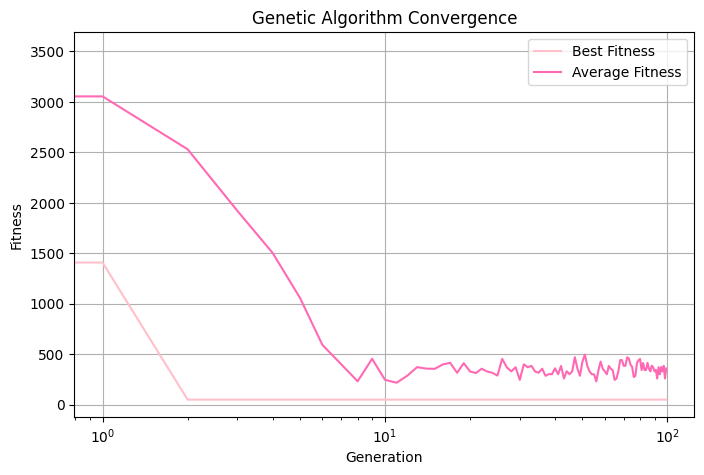


[ SMALL PROBLEM ] finished in 0:00:00.198150.
  -> Best cost: 50.3359
  -> Best chromosome: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]
  -> #Candidates: 18
  -> #Stations: 3
  -> A* calls: total=14850, real=214
  -> #Evaluations: total=10100, real=275


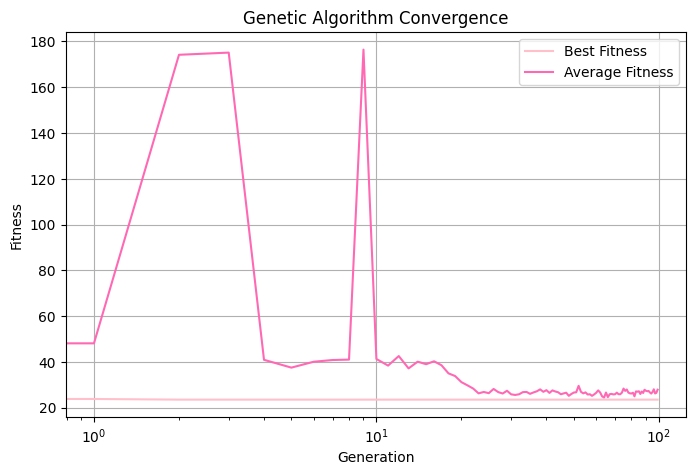


[ MEDIUM PROBLEM ] finished in 0:00:00.206960.
  -> Best cost: 23.5632
  -> Best chromosome: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]
  -> #Candidates: 25
  -> #Stations: 4
  -> A* calls: total=113100, real=450
  -> #Evaluations: total=10100, real=1131


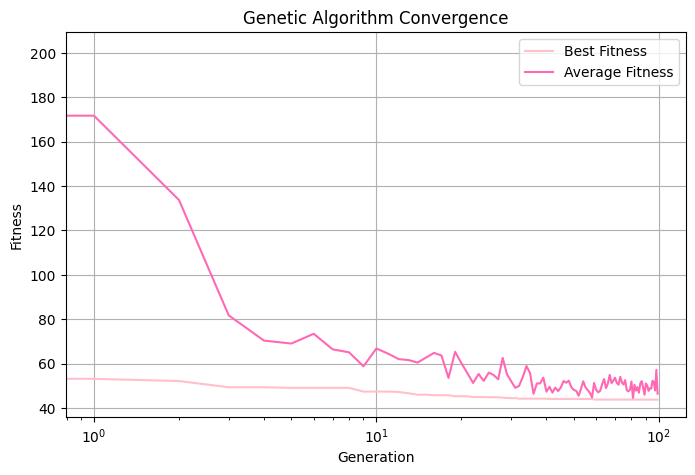


[ LARGE PROBLEM ] finished in 0:00:01.084780.
  -> Best cost: 43.7789
  -> Best chromosome: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
  -> #Candidates: 122
  -> #Stations: 8
  -> A* calls: total=3345728, real=14402
  -> #Evaluations: total=10100, real=3428


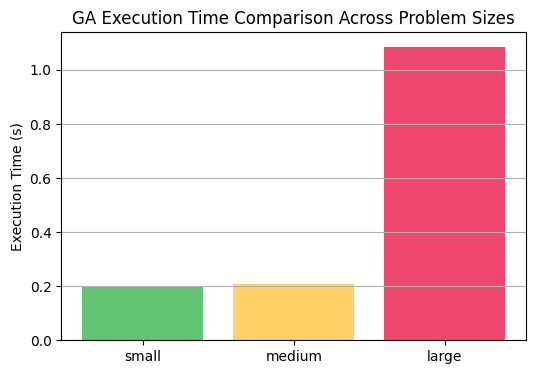


All three problems completed. Execution times (seconds):
  small: 0.198 s
  medium: 0.207 s
  large: 1.085 s


In [100]:
if __name__ == "__main__":
    main()